## mnsist classifier using pytorch

adapted from https://pytorch.org/tutorials/beginner/nn_tutorial.html

### Where to run this notebook

You can run this locally; i.e. not on paperspace. You will need to install pytorch. You can find instructions here: 
https://pytorch.org/

This notebook should be uploaded to a directory that contains a data subdirectory. If needed, create the data subdirectory manually.

### get the mnist data

In [1]:
import torchvision.models as models

#Get Resnet
network = models.resnet18(pretrained=True)

In [2]:
# Library Imports
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch as torch
import numpy as np
import os
    
from pathlib import Path
import pickle
import gzip
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import torchvision.transforms as transforms
import cv2

In [3]:
# Variables/functions for help reading the data
datapath = "./tiny-imagenet-200/"
trainpath = datapath + "train/"
classIDs = os.listdir(trainpath)
classIDDict = {}
for i in range(len(classIDs)):
    classIDDict[classIDs[i]] = i

classCount = len(classIDs)
sourceDim = 64
targetDim = 224
channels = 3

trainPerClass = 450   #500 original
testPerClass = 10
validPerClass = 20

imageCountTr = classCount  * trainPerClass
imageCountTs = classCount  * testPerClass
imageCountV = classCount  * validPerClass

# Turn single-channel images into 3-channel images
def stackImage(image):
    return np.stack((im,)*channels, axis=-1)

# Helper function for resizing and normalizing images
def processImage(image):
    if (len(image.shape) < channels):
        image = stackImage(image)
    asfloat = image.astype('float32')
    resized = cv2.resize(asfloat, dsize=(targetDim,targetDim), interpolation=cv2.INTER_CUBIC)
    rolled = np.rollaxis(resized, 2, 0)
    tensor = torch.tensor(rolled)
    normalized = normalize(tensor)
    numpied = normalized.numpy()[:,:,:]
    return numpied

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [4]:
#training, test, validation data
imagesTr = np.zeros((imageCountTr, channels, targetDim, targetDim), dtype="float32")
labelsTr = np.zeros(imageCountTr, dtype=int)

imagesTs = np.zeros((imageCountTs, channels, targetDim, targetDim), dtype="float32")
labelsTs = np.zeros(imageCountTs, dtype=int)

imagesV = np.zeros((imageCountV, channels, targetDim, targetDim), dtype="float32")
labelsV = np.zeros(imageCountV, dtype=int)

dataset = [(imagesTr, labelsTr), (imagesTs, labelsTs), (imagesV, labelsV)]

for i in range(len(classIDs)):
    fileNames = glob.glob(trainpath+classIDs[i]+"/images/*.JPEG")
    j = 0
    for s in dataset:
        length = int(len(s[0]) / classCount)
        for k in range(length):
            classIndex = j + k
            setIndex = i * length + k
            im = mpimg.imread(fileNames[classIndex].replace("\\", "/"))
            im = processImage(im)
            label = i
            s[0][setIndex] = im
            s[1][setIndex] = label 
        j += length
    print('Class: ' + str(i))

Class: 0
Class: 1
Class: 2
Class: 3
Class: 4
Class: 5
Class: 6
Class: 7
Class: 8
Class: 9
Class: 10
Class: 11
Class: 12
Class: 13
Class: 14
Class: 15
Class: 16
Class: 17
Class: 18
Class: 19
Class: 20
Class: 21
Class: 22
Class: 23
Class: 24
Class: 25
Class: 26
Class: 27
Class: 28
Class: 29
Class: 30
Class: 31
Class: 32
Class: 33
Class: 34
Class: 35
Class: 36
Class: 37
Class: 38
Class: 39
Class: 40
Class: 41
Class: 42
Class: 43
Class: 44
Class: 45
Class: 46
Class: 47
Class: 48
Class: 49
Class: 50
Class: 51
Class: 52
Class: 53
Class: 54
Class: 55
Class: 56
Class: 57
Class: 58
Class: 59
Class: 60
Class: 61
Class: 62
Class: 63
Class: 64
Class: 65
Class: 66
Class: 67
Class: 68
Class: 69
Class: 70
Class: 71
Class: 72
Class: 73
Class: 74
Class: 75
Class: 76
Class: 77
Class: 78
Class: 79
Class: 80
Class: 81
Class: 82
Class: 83
Class: 84
Class: 85
Class: 86
Class: 87
Class: 88
Class: 89
Class: 90
Class: 91
Class: 92
Class: 93
Class: 94
Class: 95
Class: 96
Class: 97
Class: 98
Class: 99
Class: 100

In [5]:
# Convert data to tensor
x_train, y_train = imagesTr, labelsTr
x_valid, y_valid = imagesV, labelsV
x_train, y_train, x_valid, y_valid = map(
    torch.as_tensor, (x_train, y_train, x_valid, y_valid)) 

In [6]:
# Switch to GPU
if torch.cuda.is_available(): 
    dev = "cuda:0" 
    device = torch.device(dev)
    network.to(device);

In [7]:
# Tensor Dataset from tensors
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [8]:
#Create DataLoader
import torch

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess1(x):
    return x.view(-1, channels, targetDim, targetDim)

def preprocess2(x, y):
    return x.view(-1, channels, targetDim, targetDim), y



In [9]:
# define log softmax and our model output

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# negative loss likelihood (equivalent to cross entropy)
def nll(inp, target):
    return -inp[range(target.shape[0]), target].mean()

# Define our loss function and accuracy
loss_func = F.cross_entropy
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

### Training loop

In [10]:
# Loss for a full batch
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = yb.long()
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

# Fit model to data
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # Training loop
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                val_loss, nums = loss_batch(model, loss_func, xb, yb)
                epoch_val_loss +=  val_loss
            epoch_val_loss /= nums
        print(epoch, epoch_val_loss)

In [11]:
# Hyperparameters
bs = 32
lr = 2.85e-3  # learning rate
epochs = 5  # how many epochs to train for

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

In [12]:
# Wrap dataloader and get parameters
train_dl = WrappedDataLoader(train_dl, preprocess2)
valid_dl = WrappedDataLoader(valid_dl, preprocess2)
opt = optim.SGD(network.parameters(), lr=lr, momentum=0.9)

In [ ]:
#Train Model
fit(epochs, network, loss_func, opt, train_dl, valid_dl)

0 3.444652395322919
1 3.0606869719922543
2 2.9786742124706507


In [16]:
#Save Network
torch.save(network, './resnet.pt')

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-03


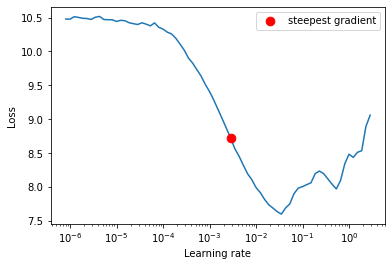

In [24]:
#Learning rate finder, used for learning rate above
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(network, optimizer, criterion, device=dev)
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [18]:
# See network
network = torch.load('./resnet.pt')
network

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# Compute accuracy on validation set (test set not labeled)
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

val_acc = 0
counter = 0
with torch.no_grad():
    for xb, yb in valid_dl:
        xb, yb = xb.to(device), yb.to(device)
        out = network(xb)
        val_acc += accuracy(out, yb)
        counter += 1
print(val_acc/counter)

tensor(0.6322, device='cuda:0')
